# **Creating results for 2 dimensional Riemann problems**
This notebook is for easily creating results to use in the thesis. The code is based on code from the development stage, found in `dev_pkg_2dim.ipynb` which is a notebook used for testing everything while developing.

This notebook differs from 2dim-notebook in the sense that we in this case test with new data with additional 1 parameter, namely max_T. This such that one might add delta_t for more promessing results.

## **How to produce results**
1. Choose parameters. Be wise on choice of destination to avoid overwriting.
2. Restart kernel and run all cells.

**NB**: `Make sure not to overwrite wanted material, thus choose destination and filename with care`**!!!**

In [ ]:
from datetime import datetime
print("Last run:",datetime.today())

## Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from riemannsolver import data2d
from riemannsolver import net_mlp2d as network
from riemannsolver import god_mlp2d_newParam as god_aprox
from riemannsolver import netplot
from riemannsolver import function

from riemannsolver import godunov as god_exact

#from IPython.display import HTML
from tqdm import tqdm_notebook as tqdm

## **Parameters**

#### Flux and derivative in x-direction and y-direction

In [3]:
f = lambda x: x**2/2
dfdu = lambda x: x

g = lambda x: x**2/2
dgdu = lambda x: x

#### Destination and filename 

In [4]:
destination = "res/2dim_newParam/burgers/test"
name = "test"

#### Data
* val_size - size of validation data (must not exceed size of all data combined).
* data_dest - destination of where to fetch data.
* datasets - a list of the filename of all data to fetch.

In [5]:
val_size = 10000
data_dest = 'res/2dim_newParam/burgers/data/data2d_7in_finalSet_210113'
datasets = ['data_1000_burgers_N100_'+str(i)+'.pt' for i in range(0,110)] # A set of totally 110.000 data points.
#val_size = 200
#data_dest = 'res/2dim_newParam/burgers/data'
#datasets = ['data_100_burgers_N300_'+str(i)+'.pt' for i in range(110,120)] + ['data_1000_burgers_N200_110.pt']

#### Network parameters

In [6]:
hidden_layers = (8,8,8,)
epochs = 20
batchsize = 100

#### Mesh- and method-parameters
To enhance performance, set small $N_y$-value if y-direction in initial data is constant.
* $N_x$ - mesh size in x-direction
* $N_y$ - mesh size in y-direction
* T - temporal maximum
* C - Courant coefficient

In [7]:
Nx = 50
Ny = 3
T = 0.5
C = 0.5

## **Data**

In [8]:
data = torch.load(data_dest+'/'+datasets[0])
for i in range(1,len(datasets)):
    data = torch.cat(
        ( data,torch.load(data_dest+'/'+datasets[i]) ), dim = 0
    )

torch.manual_seed(42)

# double amount of data by using symmetry:
#tmp = torch.zeros(data.size())
#tmp[:,:] = data[:,:]
#tmp[:,0:2] = data[:,4:6]
#tmp[:,4:6] = data[:,0:2]
#data = torch.cat((data,tmp),0)
#del tmp

data = data[torch.randperm(data.size(0))]

data_val = data[:val_size,:]
data_trn = data[val_size:,:]

N = data_trn.size(0) # data sampler size

print("Training data size: %d x %d"%(data_trn.size(0),data_trn.size(1)))
print("Validation data size: %d x %d"%(data_val.size(0),data_val.size(1)))

Training data size: 100000 x 8
Validation data size: 10000 x 8


## **Network**

In [9]:
dimensions = (7,) + hidden_layers + (1,)
net = network.Network(
    N=N, 
    dimensions=dimensions,
    optimizer=torch.optim.AdamW
)

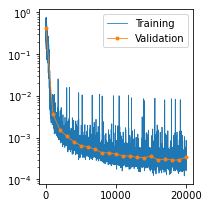

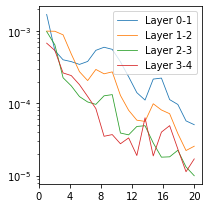

In [10]:
net.backward(
    epochs = epochs,
    batchsize = batchsize,
    data_train=data_trn,
    data_val=data_val,
    destination=destination,
    name=name
)
hist = net.history
hist_w = net.history_weight
netplt = netplot.Curve(hist, hist_w)
netplt.plot_history(destination=destination, name=name, show=True)
netplt.plot_weights(destination=destination, name=name, show=True)

## **Approximate by Godunov**

In [11]:
bounds = ['neumann' for _ in range(3)] + ['periodic']
labels = ['heavi','heavi_rev','heavi_scaled','trig']
init_funcs = [
    function.InitialFunc('heavi').func,
    function.InitialFunc('heavi_rev').func,
    function.InitialFunc('heavi_scaled').func,
    function.InitialFunc('sine1D').func
]
result = []
for init_func, bound, label in zip(init_funcs, bounds, labels):
    print("solving "+label)
    god = god_aprox.Godunov(
        f=f, dfdU=dfdu, g=g, dgdU=dgdu, U0=init_func, 
        x_min=-1.0, x_max=1.0, Nx=Nx, 
        y_min=-1.0, y_max=1.0, Ny=Ny, C=C, bnd_cond=bound, network = net.network, T=T
    )
    god.solve
    result.append(god.u[-1])

solving heavi



solving heavi_rev



solving heavi_scaled



solving trig


## **Plot**

In [12]:
y = torch.linspace(-1, 1, result[0].size(0), dtype=torch.float64)
x = torch.linspace(-1, 1, result[0].size(1), dtype=torch.float64)
y_mesh,x_mesh = torch.meshgrid(y,x)
mesh = torch.stack((x_mesh,y_mesh),axis=2)
x, y = mesh[:,:,0].numpy(), mesh[:,:,1].numpy()
z = [res.numpy() for res in result]

x_e = np.linspace(-1,1,8192)
u_e = [
    (x_e/T)*((0.0<x_e)*(x_e<T)) + (x_e>=T),
    (x_e<=T/2),
    (x_e>=T) + (x_e/T)*((T>x_e)*(x_e>-T)) - (-T>=x_e),
    torch.load('res/2dim/burgers/exact/exact_godunov_N8192_T05_C05_burgers_trig.pt').numpy()
]

#for Godunov:
u0 = [
    lambda x: (x>=0).type(torch.float64), # Heaviside
    lambda x: (x<0).type(torch.float64), # Reversed Heaviside
    lambda x: ((-1)*(x<0) + (x>0)).type(torch.float64), # Inverse
    lambda x: np.sin(4*np.pi*x) # Trigonometric
]

for i,zi,label in zip(range(len(z)),z, labels):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    # set axis names
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    # set axis values on x-and y-axes
    tick = np.linspace(-1, 1, 5)
    plt.xticks(ticks=tick,labels=tick)
    plt.yticks(ticks=tick,labels=tick)
    # set z-axis limit
    axMax = np.max(zi)+0.01*np.max(zi)
    axMin = np.min(zi)+0.01*np.min(zi)
    ax.set_zlim(axMin,axMax)
    # set view angle
    ax.view_init(15,-110)
    im = ax.plot_surface(x, y , zi, ccount=1000, cmap='coolwarm',shade=False, alpha=0.5)
    im = ax.plot_wireframe(x, y , zi, rstride=100,cstride=200, color="k",ls='--', alpha=0.8)
    plt.savefig(destination+'/'+label+'_network_3D'+'.pdf',format='pdf')
    plt.close()

    fig = plt.figure(figsize=(5,5))
    im = plt.imshow(
        zi,
        cmap='coolwarm',
        extent=[-1,1,-1,1],
        vmin=np.min(zi)-0.01,
        vmax=np.max(zi)+0.01
    )
    tick = np.linspace(-1, 1, 5)
    plt.colorbar(im, pad=0.04)
    plt.xticks(ticks=tick,labels=tick)
    plt.yticks(ticks=tick,labels=tick)
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.savefig(destination+'/'+label+'_network_color'+'.pdf',format='pdf')
    plt.close()
    
    #solve wrt Godunov - with mesh size Nx
    god_g = god_exact.Godunov(
        f=f, dfdu=dfdu, u0=u0[i], 
        bnd_cond=bounds[i], 
        xmin=-1, xmax=1, Nx=Nx, 
        T=T, C=C
    )
    god_g.solve
    u_g = god_g.u[-1]
    x_g = god_g.x
    
    u = torch.mean(result[i],dim=0)
    x = torch.linspace(-1,1, len(u))
    plt.figure(figsize=(3,3))
    plt.plot(x_e,u_e[i],'C0',lw=0.8)
    plt.plot(x,u,'C1.-',lw=0.8)
    plt.plot(x_g, u_g,'C2--',lw=0.8)
    plt.xlabel('x')
    plt.ylabel('u',rotation=0)
    plt.tight_layout()
    plt.savefig(destination+'/'+labels[i]+'_network_2D.pdf',format='pdf')
    plt.close()
    
    re = float(
        torch.sqrt(
            torch.sum( (u-u_g)**2 )/torch.sum( (u_g)**2 )
        )
    )
    print("Relative error - godunov vs network: ",re)
    print(u_g.size())


Relative error - godunov vs network:  0.06135792701224033
torch.Size([50])



Relative error - godunov vs network:  0.11326781156668811
torch.Size([50])



Relative error - godunov vs network:  0.10778670396001427
torch.Size([50])



Relative error - godunov vs network:  0.6728556441681922
torch.Size([50])
